<a href="https://colab.research.google.com/github/jwengr/dacon/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%82%AC%EC%9A%A9%EC%9E%90%20%EC%97%B0%EC%B2%B4%20%EC%98%88%EC%B8%A1%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/WideDeepNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [564]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from itertools import combinations
from transformers import BertTokenizer
from sklearn.preprocessing import StandardScaler

In [247]:
PATH = 'drive/My Drive/dacon/credit'

In [699]:
train_df = pd.read_csv(PATH+'/dataset/train.csv').drop(['index','FLAG_MOBIL'],axis=1)
test_df = pd.read_csv(PATH+'/dataset/test.csv').drop(['index','FLAG_MOBIL'],axis=1)

In [700]:
train_df['occyp_type'].fillna('one two three',inplace=True)
test_df['occyp_type'].fillna('one two three',inplace=True)

In [701]:
train_df['not_employed'] = (train_df['DAYS_EMPLOYED']>0).astype(np.int32)
test_df['not_employed'] = (test_df['DAYS_EMPLOYED']>0).astype(np.int32)

In [702]:
train_df['begin_months'] = train_df['begin_month'].values%12
test_df['begin_months'] = test_df['begin_month'].values%12

In [703]:
le = preprocessing.LabelEncoder()

In [704]:
for col in ['gender','car','reality','work_phone','phone','email','not_employed','begin_months','family_size']:
    train_df[[col]] = le.fit_transform(train_df[[col]]).astype(np.int32)
    train_df = pd.concat([train_df,pd.get_dummies(train_df[col],prefix=f'{col}')],axis=1)

    test_df[[col]] = le.fit_transform(test_df[[col]]).astype(np.int32)
    test_df = pd.concat([test_df,pd.get_dummies(test_df[col],prefix=f'{col}')],axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [705]:
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    train_df = pd.concat([train_df,pd.get_dummies(train_df[col],prefix=f'{col}')],axis=1)
    test_df = pd.concat([test_df,pd.get_dummies(test_df[col],prefix=f'{col}')],axis=1)

In [706]:
dummies_df = train_df.iloc[:,34:]
train_df = train_df.iloc[:,:34]

test_dummies_df = pd.DataFrame(columns=dummies_df.columns)
for col in test_df.iloc[:,33:].columns:
    test_dummies_df[col] = test_df[col]
test_dummies_df.fillna(0,inplace=True)
test_df = test_df.iloc[:,:33]

In [707]:
dummies_arr = dummies_df.values
test_dummies_arr = test_dummies_df.values

In [708]:
dummies_arr.shape,test_dummies_arr.shape

((26457, 62), (10000, 62))

In [709]:
wide_arr = np.zeros((len(train_df),dummies_arr.shape[1]*(dummies_arr.shape[1]-1)//2),dtype=np.int32)
test_wide_arr = np.zeros((len(test_df),test_dummies_arr.shape[1]*(test_dummies_arr.shape[1]-1)//2),dtype=np.int32)

In [710]:
i=0
for a,b in list(combinations(range(dummies_arr.shape[1]),2)):
    wide_arr[:,i] = dummies_arr[:,a]*dummies_arr[:,b]
    i+=1
i=0
for a,b in list(combinations(range(test_dummies_arr.shape[1]),2)):
    test_wide_arr[:,i] = test_dummies_arr[:,a]*test_dummies_arr[:,b]
    i+=1

In [711]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [712]:
print('----train----')
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    print(col,max([len(tokenizer.encode(val)) for val in set(train_df[col].values)]))
print('----test----')
for col in ['income_type','edu_type','family_type','house_type','occyp_type']:
    print(col,max([len(tokenizer.encode(val)) for val in set(test_df[col].values)]))

----train----
income_type 4
edu_type 6
family_type 6
house_type 6
occyp_type 8
----test----
income_type 4
edu_type 6
family_type 6
house_type 6
occyp_type 8


In [713]:
emb_arr = np.zeros((len(train_df),3+5+5+5+7),np.int32)
test_emb_arr = np.zeros((len(test_df),3+5+5+5+7),np.int32)

In [714]:
last=0
for col,max_length in zip(['income_type','edu_type','family_type','house_type','occyp_type'],[4,6,6,6,8]):
    emb_arr[:,last:last+max_length-1] = np.array(train_df[col].apply(lambda x: tokenizer.encode_plus(x,padding='max_length',max_length=max_length)['input_ids'][1:]).values.tolist())
    last+=max_length-1
last=0
for col,max_length in zip(['income_type','edu_type','family_type','house_type','occyp_type'],[4,6,6,6,8]):
    test_emb_arr[:,last:last+max_length-1] = np.array(test_df[col].apply(lambda x: tokenizer.encode_plus(x,padding='max_length',max_length=max_length)['input_ids'][1:]).values.tolist())
    last+=max_length-1

In [715]:
for col in ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','family_size','begin_month']:
    scaler = StandardScaler()
    train_df[f'{col}_scaled'] = scaler.fit_transform(train_df[[col]])
    test_df[f'{col}_scaled'] = scaler.transform(test_df[[col]])

In [716]:
deep_arr = train_df[['gender','car','reality','child_num','work_phone','phone','email',
          'income_total_scaled','DAYS_BIRTH_scaled','DAYS_EMPLOYED_scaled','family_size_scaled','begin_month_scaled']].values
test_deep_arr = test_df[['gender','car','reality','child_num','work_phone','phone','email',
          'income_total_scaled','DAYS_BIRTH_scaled','DAYS_EMPLOYED_scaled','family_size_scaled','begin_month_scaled']].values

In [717]:
deep_arr = np.concatenate((deep_arr,emb_arr),axis=1)
test_deep_arr = np.concatenate((test_deep_arr,test_emb_arr),axis=1)

In [718]:
deep_arr.shape,wide_arr.shape,test_deep_arr.shape,test_wide_arr.shape,

((26457, 37), (26457, 1891), (10000, 37), (10000, 1891))

In [734]:
dataset = tf.data.Dataset.from_tensor_slices(((np.concatenate((deep_arr,wide_arr),axis=1)),pd.get_dummies(train_df['credit'].astype(np.int32)).values)).shuffle(26457)
test_dataset = tf.data.Dataset.from_tensor_slices(np.concatenate((test_deep_arr,test_wide_arr),axis=1)).batch(256)

In [725]:
train_dataset, test_dataset = dataset.take(int(26457*0.9)).batch(256), dataset.skip(int(26457*0.9)).batch(256)

In [726]:
inputs = keras.Input(shape=(deep_arr.shape[1]+wide_arr.shape[1]))
deep,wide = Lambda( lambda x: tf.split(x,num_or_size_splits=[deep_arr.shape[1],wide_arr.shape[1]],axis=1))(inputs)

deep = layers.BatchNormalization()(deep)
deep = layers.Dense(32,activation='relu')(deep)
deep = layers.Dense(12,activation='relu')(deep)
deep = layers.Dense(3,activation='relu')(deep)


wide = layers.BatchNormalization()(wide)
wide = layers.Dense(3,activation='relu')(wide)


x = layers.Multiply()([deep,wide])
outputs = layers.Dense(3,activation='softmax')(x)

In [727]:
model = keras.Model(inputs, outputs, name="wide_deep_model")
model.summary()

Model: "wide_deep_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 1928)]       0                                            
__________________________________________________________________________________________________
lambda_56 (Lambda)              [(None, 37), (None,  0           input_55[0][0]                   
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 37)           148         lambda_56[0][0]                  
__________________________________________________________________________________________________
dense_204 (Dense)               (None, 32)           1216        batch_normalization_39[0][0]     
____________________________________________________________________________________

In [728]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=100,verbose=1)
mc = ModelCheckpoint(PATH+'/model/wide_deep.h5', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(train_dataset,
                        epochs=1000,
                        verbose=1,
                    callbacks=[early_stop, mc],
                    validation_data=test_dataset
                    )

Epoch 1/1000
94/94 [==============================] - 2s 15ms/step - loss: 1.0186 - val_loss: 0.9139
Epoch 2/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8803 - val_loss: 0.8669
Epoch 3/1000
94/94 [==============================] - 1s 12ms/step - loss: 0.8679 - val_loss: 0.8642
Epoch 4/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8542 - val_loss: 0.8573
Epoch 5/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8489 - val_loss: 0.8397
Epoch 6/1000
94/94 [==============================] - 1s 12ms/step - loss: 0.8416 - val_loss: 0.8268
Epoch 7/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8308 - val_loss: 0.8305
Epoch 8/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8378 - val_loss: 0.8250
Epoch 9/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8287 - val_loss: 0.8188
Epoch 10/1000
94/94 [==============================] - 1s 11ms/step - loss: 0.8217 - val_lo

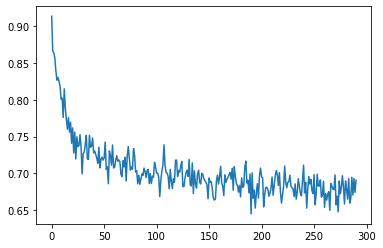

In [729]:
plt.plot(history.history['val_loss'])

In [730]:
saved_model = tf.keras.models.load_model(PATH+'/model/wide_deep.h5')

In [731]:
submission = pd.read_csv(PATH+'/dataset/sample_submission.csv')

In [735]:
submission.iloc[:,1:] = saved_model.predict(test_dataset)

In [736]:
submission.head(20)

,index,0,1,2
0,26457,5.802666e-02,8.018202e-02,0.861791
1,26458,4.024419e-02,3.384508e-02,0.925911
2,26459,1.405869e-01,1.648751e-01,0.694538
3,26460,1.296501e-01,1.374746e-01,0.732875
4,26461,2.760883e-02,1.055642e-01,0.866827
5,26462,5.673752e-02,1.077523e-01,0.835510
6,26463,3.536673e-01,6.455706e-01,0.000762
7,26464,1.104691e-01,1.948309e-01,0.694700
8,26465,7.400550e-02,2.069490e-01,0.719045
9,26466,2.590980e-01,3.224090e-01,0.418493


In [737]:
submission.to_csv(PATH+'/result/wide-deep3.csv',index=False)